# Coordinate Ascent Variational Inference on Probabilistic Count Matrix Factorization

Note: when N != P, there is an identifiability issue if alpha_k2 goes to zero or beta_k2 goes to infinity or vice-versa.

We generate data according to the non-sparse pCMF model of https://arxiv.org/pdf/1710.11028.pdf. We define 2 clusters. Inference is done via CAVI, as in the paper, where data sets with N in [100, 1000] and P in [1000, 10000] are considered. In this setting we can compare CAVI to Gibbs sampling. 

In the paper, they also estimate the hyperparameters using Variational Bayes EM, using CAVI on the E-step and 

For bigger N, Stochastic VI can be used. To improve the performance (lower the sensitivity to local optima), we can try Structured VI, both for small N (non-stochastic) and big N (stochastic). For big N, we can also use Stochastic Gradient Langevin Dynamics to guarantee a good estimate at a low computational cost. To improve scalability with P while maintaining good convergence properties, we can use one of these: approximate MCMC, embarrassingly-parallel MCMC, data augmentation MCMC, hybrid Bayesian inference.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, klqp
import plot_utils

from ZIFA import ZIFA

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import gamma

plt.style.use('ggplot')

## Data generation

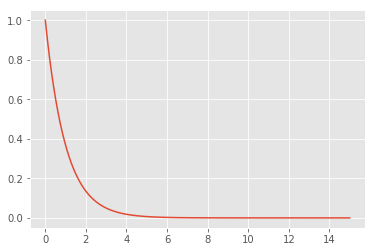

In [2]:
# Look at the Gamma pdf to help deciding the prior parameters for U estimation
a = 1.
b = 1.

x = np.linspace(0, 15, 1000)

prior_pdf = gamma.pdf(x, a, scale=1./b) 
plt.plot(x, prior_pdf)
plt.show()

In [3]:
# Experiment parameters
N = 100 # number of observations
P = 20 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

z_p_arr = [0., 0.3, 0.6] # none, low, high ZI
eps_arr = [2., 10.] # low, high separability
n_runs = 10 # number of experiments per setting

zi_debug_strs = ['NO zero-inflation', 'LOW zero-inflation', 'HIGH zero-inflation']
eps_debug_strs = ['LOW separability', 'HIGH separability']

pca_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))
zifa_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))
pcmf_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))

for i in range(len(z_p_arr)):
    print('%s:' % zi_debug_strs[i])
    for j in range(len(eps_arr)):
        print('\t%s' % eps_debug_strs[j])
        for k in range(n_runs):
            # Generate data set
            Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p_arr[i], 
                                                             eps=eps_arr[j], return_all=True)
            log_Y = np.log(1 + Y)

            # Run PCA
            pca = PCA(n_components=2).fit_transform(Y)

            # Run ZIFA
            zifa, _ = ZIFA.fitModel(log_Y, K, test_input=False, verbose=False)
            
            # Run CAVI and get estimates (pCMF)
            alpha = np.ones((2, K))
            alpha[0, :] = 3.
            alpha[1, :] = 0.5
            beta = np.ones((2, P, K))
            pi = np.ones((P,)) * 0.5
            cavi = klqp.CoordinateAscentVI(Y, alpha, beta, pi)
            cavi.run_cavi(n_iterations=200, return_elbo=False, verbose=False)
            est_U = cavi.a[0] / cavi.a[1]

            # Calculate silhouette scores method
            pca_silh = silhouette_score(pca, clusters)
            zifa_silh = silhouette_score(zifa, clusters)
            pcmf_silh = silhouette_score(est_U, clusters)

            # Store scores in array
            pca_scores[i, j, k] = pca_silh
            zifa_scores[i, j, k] = zifa_silh
            pcmf_scores[i, j, k] = pcmf_silh
    print('')

# Prepare arrays to plot
no_zi_low_sep = [pca_scores[0, 0, :], zifa_scores[0, 0, :], pcmf_scores[0, 0, :]]
no_zi_high_sep = [pca_scores[0, 1, :], zifa_scores[0, 1, :], pcmf_scores[0, 1, :]]

low_zi_low_sep = [pca_scores[1, 0, :], zifa_scores[1, 0, :], pcmf_scores[1, 0, :]]
low_zi_high_sep = [pca_scores[1, 1, :], zifa_scores[1, 1, :], pcmf_scores[1, 1, :]]

high_zi_low_sep = [pca_scores[2, 0, :], zifa_scores[2, 0, :], pcmf_scores[2, 0, :]]
high_zi_high_sep = [pca_scores[2, 1, :], zifa_scores[2, 1, :], pcmf_scores[2, 1, :]]

NO zero-inflation:
	LOW separability
	HIGH separability

LOW zero-inflation:
	LOW separability
	HIGH separability

HIGH zero-inflation:
	LOW separability
	HIGH separability



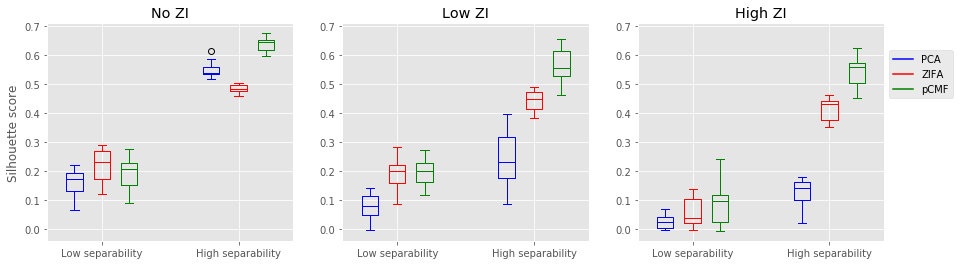

In [6]:
# Plot silhouette scores
legend=['PCA', 'ZIFA', 'pCMF']
fig = plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)
plot_utils.plot_simulation_results(no_zi_low_sep, no_zi_high_sep, ax=ax1, ylabel='Silhouette score', title='No ZI')

ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plot_utils.plot_simulation_results(low_zi_low_sep, low_zi_high_sep, ax=ax2, title='Low ZI')

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
_, handles = plot_utils.plot_simulation_results(high_zi_low_sep, high_zi_high_sep, ax=ax3, legend=legend, title='High ZI')

plt.legend(handles, legend, labelspacing=0.5, bbox_to_anchor=(1.3, 0.9))
_ = [h.set_visible(False) for h in handles]

plt.show()

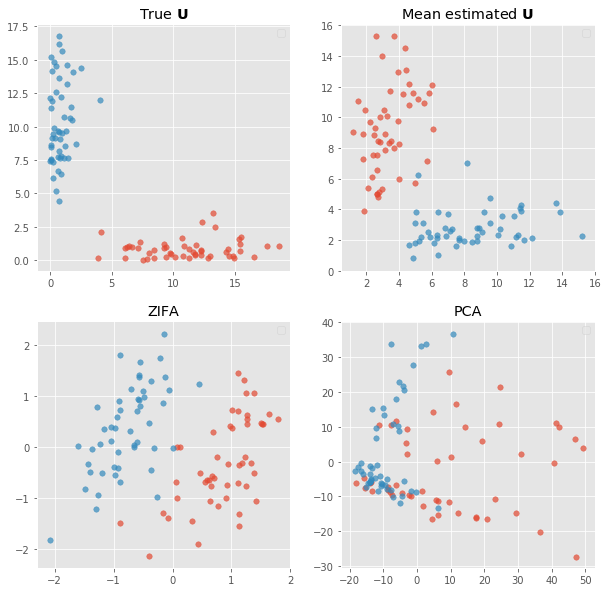

In [5]:
# Plot lower-dimensional embeddings
s = 30
alpha = 0.7
labels=[]
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
handlers = []
for c in range(C):
    h = ax1.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(2, 2, 2)
handlers = []
for c in range(C):
    h = ax2.scatter(est_U[int(c*N/C):int((c+1)*N/C), 0], est_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('Mean estimated $\mathbf{U}$')

ax3 = plt.subplot(2, 2, 3)
handlers = []
for c in range(C):
    h = ax3.scatter(zifa[int(c*N/C):int((c+1)*N/C), 0], zifa[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('ZIFA')

ax4 = plt.subplot(2, 2, 4)
handlers = []
for c in range(C):
    h = ax4.scatter(pca[int(c*N/C):int((c+1)*N/C), 0], pca[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax4.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()